## Data preprocessing
Reads the nodules mask, associates it with the malignancy and  

In [106]:
import SimpleITK as sitk
import readingXMLSegmentation
reload(readingXMLSegmentation)
import pandas
import matplotlib.pyplot as plt
import os
import numpy as np
import skimage, skimage.measure
%matplotlib inline
import radiomics

In [107]:
csvPath = 'DATA_LUNA/CSVFILES/annotations.csv'
nodules = pandas.read_csv(csvPath)
xmlPath = 'LIDC/LIDC-XML_radiologist_anotations/tcia-lidc-xml/'
imagePath = 'DATA_LUNA/all_subsets/'

In [108]:
patients = set(nodules.seriesuid.values)
print '#patients with nodules', len(patients)

#patients with nodules 601


In [109]:
#Get a scan, get its segmentations, and link it to malignancy.
#Extract a numpy array with (image), and a csv with malignancy, spicatulation, etc, radiomics property, and identifier.

In [110]:
readingXMLSegmentation.generate_csv_xml_path(xmlPath, patients, 'DATA_LUNA/CSVFILES/patientIdToCSV.csv')

In [105]:
patientsToCSV = pandas.read_csv('DATA_LUNA/CSVFILES/patientIdToCSV.csv')
patientsToCSV.index = patientsToCSV.pId

## Test
Process a single element:

1) Extract manual segmentation 

2) Link with malignancy/ etc

3) Add position features

In [118]:
pIdTest = patientsToCSV.index.values[0]
xmlPath = patientsToCSV.loc[pIdTest , 'xmlPath']

#Reading
image = sitk.ReadImage(os.path.join(imagePath, pIdTest +'.mhd'))
nodulesPatient = nodules.loc[nodules['seriesuid'] == pIdTest]

In [119]:
reload(readingXMLSegmentation)

<module 'readingXMLSegmentation' from 'readingXMLSegmentation.pyc'>

In [120]:
mask = readingXMLSegmentation.getNoduleMaskFromXML(xmlPath, image)
maskSitk = sitk.GetImageFromArray(mask)
maskSitk.SetSpacing(image.GetSpacing())
maskSitk.SetOrigin(image.GetOrigin())

In [121]:
#Link with nodules list
labels = skimage.measure.label(mask)
rProps = skimage.measure.regionprops(labels)

In [122]:
def centroidDifferences(nodule, centroid):
    return np.linalg.norm([nodule.coordX - centroid[0],nodule.coordY - centroid[1],nodule.coordZ - centroid[2]])

In [123]:
def extract_radiomic_features(patient_id, img, nodule_mask, spacing = [1, 1,1], add ={}):
    settings = {}
    settings['binWidth'] = 25
    settings['resampledPixelSpacing'] = None
    # settings['resampledPixelSpacing'] = [3, 3, 3]  # This is an example for defining resampling (voxels with size 3x3x3mm)
    settings['interpolator'] = 'sitkBSpline'
    settings['verbose'] = True

    extractor = featureextractor.RadiomicsFeaturesExtractor(**settings)

    labels, nLabels =skimage.measure.label(nodule_mask, return_num = True)
    allNodules = []
    print ('nlabels = ', nLabels)
    for i in xrange(1,nLabels + 1):

        # change npz data to integer (for pyradiomics)
        mask = (labels == i).astype(np.int8)
        print ('label %d, number of voxels = %d' % (i, np.sum(mask)))

        # change image format to SimpleITK (for pyradiomcis)
        imgSitk = sitk.GetImageFromArray(img)
        imgSitk.SetSpacing(spacing)
        maskSitk = sitk. GetImageFromArray(mask)
        maskSitk.SetSpacing(spacing)
        # exctract features
        print('Calculating features')
        featureVector = extractor.execute(imgSitk, maskSitk)

        # create dataframe
        feature_list = featureVector.items()[12:]
        patient_radiomics = pd.DataFrame(feature_list)

        patient_radiomics = patient_radiomics.transpose()
        patient_radiomics.columns = patient_radiomics.iloc[0]

        patient_radiomics = patient_radiomics.reindex(patient_radiomics.index.drop(0))

        patient_radiomics['patientid'] = patient_id
        patient_radiomics['num_features'] = len(feature_list)
        patient_radiomics['nodule_id'] = i
        for k, v in add.iteritems():
            patient_radiomics[k] = np.max(v[np.where(mask)])
        allNodules.append(patient_radiomics)
    return allNodules


In [124]:
if len(rProps) != len(nodulesPatient):
    errors.append(pId)
    print 'Error in patient', pId, 'number of anotated nodules %d / in csv %d ' % (len(rProps), len(nodulesPatient))
for r in rProps:
    centroidPatientCoordinatesrProps = r.centroid[::-1] * np.array(image.GetSpacing()) + np.array(image.GetOrigin())
    for i,nod in nodulesPatient.iterrows():
        print centroidDifferences(nod, centroidPatientCoordinatesrProps)

0.3741301051156932
78.10062653811335
78.512892065981
0.18991017971651505


In [125]:
imageNP = sitk.GetArrayViewFromImage(image)

'/home/enric/anaconda2/bin/python'

In [126]:
fe = radiomics.featureextractor.RadiomicsFeaturesExtractor()

AttributeError: 'module' object has no attribute 'featureextractor'

In [278]:
fe.computeFeatures(image, mask, 'sitk')

AttributeError: 'numpy.ndarray' object has no attribute 'GetPixelIDValue'

In [279]:
mask.shape

(182, 512, 512)

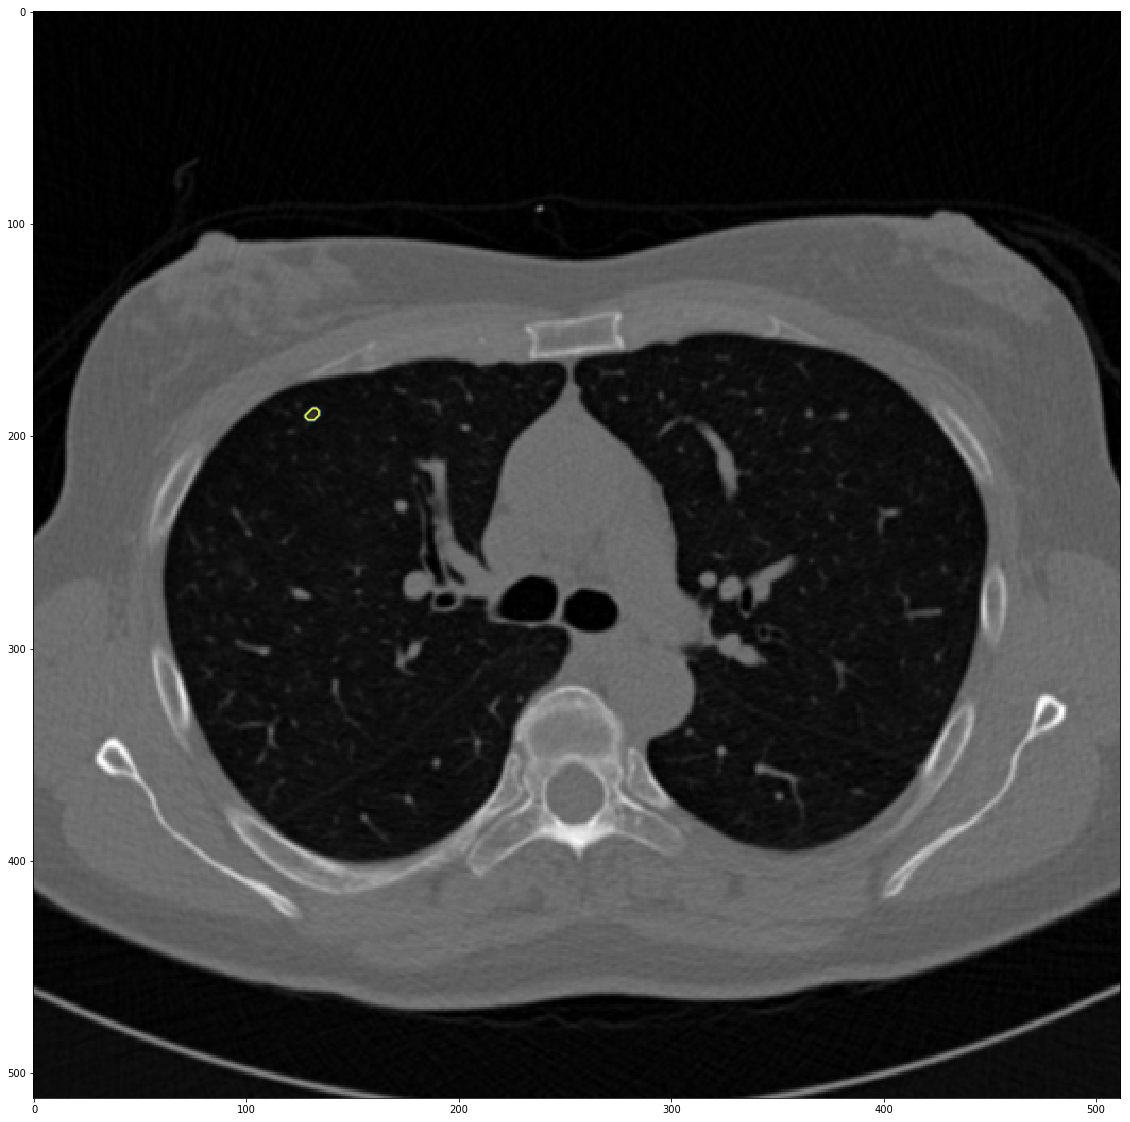

In [286]:
plt.figure(figsize = (20, 20))
plt.imshow(imageNP[123, :, :], cmap = 'gray')
#plt.scatter(130, 190, c = 'r')
plt.contour(mask[123, :, :])